# ObsAstro - Photometry

Written by Macarena G. del Valle-Espinosa \
Last Update: January 12, 2024 by Macarena G. del Valle-Espinosa \
Observational Astronomy - Computer Lab - University of Edinburgh

## Introduction 

In this exercise, you will perform aperture photometry to a standard star in different filters and elevations to calculate the extinction coefficient. You will then compare the measured magnitudes to the real ones to calibrate the instrument. Later, you will perform aperture photometry on 25 galaxies which might be part of a galaxy cluster. By comparing their magnitudes and the (v-i) color, you will be able to measure the red sequence and decide which galaxies are indeed part of the cluster and which ones are more likely foreground objects. 

Here is the list of general packages we are going to use. \
Through the notebook you will see more specific packages and dedicated functions you will also need.

In [10]:
pip install matplotlib numpy scipy astropy

  Using cached astropy-7.0.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached pyerfa-2.0.1.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.7 kB)
  Using cached astropy_iers_data-0.2025.2.3.0.32.42-py3-none-any.whl.metadata (5.1 kB)
Using cached astropy-7.0.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
Using cached astropy_iers_data-0.2025.2.3.0.32.42-py3-none-any.whl (1.9 MB)
Using cached pyerfa-2.0.1.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (738 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pyyaml bokeh mpl_point_clicker

  Using cached mpl_point_clicker-0.4.1-py3-none-any.whl.metadata (1.2 kB)
Using cached mpl_point_clicker-0.4.1-py3-none-any.whl (6.2 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install lineid_plot pandas photutils

  Using cached lineid_plot-0.6-py2.py3-none-any.whl.metadata (704 bytes)
  Using cached photutils-2.1.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached lineid_plot-0.6-py2.py3-none-any.whl (9.6 kB)
Using cached photutils-2.1.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits

In [4]:
from bokeh.io import show, output_notebook
# set local host for bokeh (change the number to the one in the url at the top of the page)
localhost = 'localhost:8888'

In [5]:
output_notebook()

Loading BokehJS ...

<div class="alert alert-block alert-warning">

# <font color='red'>WARNING!</font> 
Through this notebook, you should replace any <font color='red'>'''text'''</font> with your own file/variable names. \
Check the `notebook_url` variable matches the one on your notebook (beginning of the url)


# Standard star analysis

First we are going to familiarise ourselves with the display interface. \
Using the function `standardPlot` you will be able to display the image of a standard star, zoom in and out, change the colormap values and create an aperture around a certain pixel

In [6]:
from photometryExercise import standardPlot

In [7]:
help(standardPlot)

Help on function standardPlot in module photometryExercise:

standardPlot(standard, notebook_url='http://localhost:8888')
    Function to display the standard star image, change the colorbar and display
    and modified the object and sky apertures 
    INPUTS:
        - standard: np.array image of the standard star
        - notebook_url: the notebook server for the session open. In order to display the interactive plot 
                        the numbers after 'localhost:' must match the notebook url. Default value is set to
                        'http://localhost:8888'



In [8]:
# Load your data here. We recommend to start first with one single standard star.
# Once you have all the code working, you can automatise the process for the rest of the standard stars

# To load the data you can use the astropy.io function `fits.open()`

standard_i_a = fits.open("standard_i_a.fits")[0].data


In [9]:
standardPlot(standard_i_a, notebook_url='http://localhost:8888')

Let's calculate now the mean value for the sky and the flux in the aperture for the standard star

In [10]:
# photutils includes different functions to define apertures, 
# as well as a function to perform the aperture photometry calculations.
# Here we are loading these functions

from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

In [11]:
# Using your values from above, you should create now your circular aperture and your sky annulus
# You will need the x and y coordinates and the radius for the aperture. 
# The size of the inner and outer radius for the sky annulus are pre-defined, 
# and depend on your aperture radius. Please, do not change these values.

xcor = 50.50
ycor = 50.50
rAperture = 14
rSkyInner = rAperture*1.5
rSkyOuter = rAperture*2

apertureStandard = CircularAperture((xcor, ycor), r=rAperture)
annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)

In [12]:
# Let's make first an estimation of the sky values in your defined annulus
# aperture_photometry returns an astropy.table with the center of the aperture and 
# the total flux on the aperture ('aperture_sum')

sky = aperture_photometry(standard_i_a, annulusSky)
#help(aperture_photometry)

print(sky)

 id xcenter ycenter    aperture_sum  
--- ------- ------- -----------------
  1    50.5    50.5 306668.5429328284


In [13]:
# To recover the mean sky value we should weight the total flux by the area of the annulus

area = np.pi * rSkyOuter**2 - (np.pi * rSkyInner**2)
skyFlux = sky['aperture_sum'].value # This is how we access astropy.table columns
meanSkyValue = skyFlux/area

print(f'The mean sky value is {meanSkyValue}')

The mean sky value is [284.59367055]


In [14]:
# Once we know the mean sky value, we can perform the aperture photometry on the standard star,
# removing first the sky value

standard = aperture_photometry(standard_i_a - meanSkyValue, apertureStandard)
standardFlux = standard['aperture_sum'].value
print(f'Total flux on aperture for the standard star {standardFlux}')

Total flux on aperture for the standard star [365321.46946083]


In [15]:
# Now, you should create a function that takes the total flux as input and returns a magnitude value
# Check the manual for details on this function

def flux_to_mag():
    return -2.5 * np.log10(standardFlux)

magnitude = flux_to_mag()
print(f'The magnitude of this standard star is {magnitude}')

The magnitude of this standard star is [-13.90668799]


In [16]:
# You should create a function as well that estimates the error on the magnitude measuments
# Check the manual for details on how to propagate the error in the magnitude

def error_in_mag():
    t = skyFlux + standardFlux # maybe use meanSkyValue
    C = standardFlux
    dC = np.sqrt(standardFlux + skyFlux)

    return (-2.5 / np.log(10) ) * (dC / C) 

error_magnitude = error_in_mag()
print(error_magnitude)

[-0.0024363]


In [17]:
# With your functions you should be able to calculate the instrumental magnitude of the standard star

instrumentalMagnitude = flux_to_mag()
instrumentalMagnitudeError = error_in_mag()

print(f'The instrumental magnitude of standard_i_a is {instrumentalMagnitude} ± {instrumentalMagnitudeError}')

The instrumental magnitude of standard_i_a is [-13.90668799] ± [-0.0024363]


In [18]:
# Automate the process

def calculate_magnitude(file, aperture, x, y):
    standardstar = fits.open(file)[0].data
    
    rSkyInner = aperture*1.5
    rSkyOuter = aperture*2

    apertureStandard = CircularAperture((x, y), r=aperture)
    annulusSky = CircularAnnulus((x, y), r_in=rSkyInner, r_out=rSkyOuter)
    sky = aperture_photometry(standardstar, annulusSky)

    area = np.pi * rSkyOuter**2 - (np.pi * rSkyInner**2)
    skyFlux = sky['aperture_sum'].value
    meanSkyValue = skyFlux/area

    standard = aperture_photometry(standardstar - meanSkyValue, apertureStandard)
    standardFlux = standard['aperture_sum'].value

    # Calculate magnitude
    magnitude = -2.5 * np.log10(standardFlux)

    # Calculate error in magnitude
    t = skyFlux + standardFlux
    C = standardFlux
    dC = np.sqrt(standardFlux + skyFlux)
    magnitude_error = (-2.5 / np.log(10) ) * (dC / C) 

    return float(magnitude[0]), float(magnitude_error[0]), float(standardFlux[0])
    

In [19]:
# Generate the results for all stars

standard_files = ["standard_i_a.fits", "standard_i_b.fits", "standard_v_a.fits", "standard_v_b.fits"]
apertures = [14.5, 14.5, 14.5, 14.5]
x = 50.50
y = 50.50

magnitudes = []
magnitude_errors = []
fluxes = []

for i in range(len(standard_files)):
    m, m_e, f = calculate_magnitude(standard_files[i], apertures[i], x, y)
    magnitudes.append(m)
    magnitude_errors.append(m_e)
    fluxes.append(f)

print(magnitudes)
print(magnitude_errors)
print(fluxes)

[-13.906534691662893, -13.857919987901688, -13.207555401806788, -13.106715649827898]
[-0.0024771790310581044, -0.0025597146348430326, -0.0029703205886052065, -0.0031609828767815394]
[365269.8923773864, 349275.39716081903, 191876.66469816605, 174858.30327648378]


You want to repeat the process described above for the 4 standard star images \
Remember to store the final results with meaningful variable names 

The end results for this part of the exercise should be: 
 * the extinction coefficient in both filters, i and v
 * the zero points (ZP) for both filters

In [20]:
sec_a = 1
sec_b = 1.5

e_i = (magnitudes[1] - magnitudes[0]) / (sec_b - sec_a)

e_v = (magnitudes[3] - magnitudes[2]) / (sec_b - sec_a)

e_i_e = np.sqrt(magnitude_errors[1]**2 + magnitude_errors[0]**2)

e_v_e = np.sqrt(magnitude_errors[3]**2 + magnitude_errors[2]**2)

print(f'e_v is {e_v}')
print(f'e_i is {e_i}')

print(f'e_v_e is {e_v_e}')
print(f'e_i_e is {e_i_e}')

e_v is 0.20167950395778078
e_i is 0.09722940752240916
e_v_e is 0.004337581946937496
e_i_e is 0.0035620997969938416


In [21]:
v_mag = 17.700
v_mag_error = 0.005

i_mag = 17.500
i_mag_error = 0.005


ZP_i_a = i_mag - magnitudes[0]
ZP_i_b = i_mag - magnitudes[1]
ZP_v_a = v_mag - magnitudes[2]
ZP_v_b = v_mag - magnitudes[3]

ZP_i_a_e = np.sqrt(i_mag_error**2 + magnitude_errors[0]**2) # i_a (zenith)
ZP_i_b_e = np.sqrt(i_mag_error**2 + magnitude_errors[1]**2) # i_b (sec_theta = 1.5)
ZP_v_a_e = np.sqrt(v_mag_error**2 + magnitude_errors[2]**2) # v_a (zenith)
ZP_v_b_e = np.sqrt(v_mag_error**2 + magnitude_errors[3]**2) # v_b (sec_theta = 1.5)

zero_points = np.array([ZP_i_a, ZP_i_b, ZP_v_a, ZP_v_b])
zero_points_errors = np.array([ZP_i_a_e, ZP_i_b_e, ZP_v_a_e, ZP_v_b_e])
print(zero_points)
print(zero_points_errors)

[31.40653469 31.35791999 30.9075554  30.80671565]
[0.00558    0.00561713 0.00581574 0.00591539]


__________

# Determining the cluster membership

Now, we are going to measure the magnitudes and (v-i) colors of galaxies and determine if they are part of a cluster. \
The process is very similar: we want to locate the objects, create apertures and sky annulus around them and calculate the magnitudes and errors.\
Using the function `clusterPlot`, you can navigate through both filters, zoom in on different galaxies, and determine their centres using your mouse (left double-click). The x and y coordinates of your selected pixels will appear on the left-hand side of the interface, allowing to copy and paste them into Python variables

In [22]:
# Let's load first both images of the cluster

cluster_v = fits.open('cluster_v.fits')[0].data
cluster_i = fits.open('cluster_i.fits')[0].data


In [23]:
from photometryExercise import clusterPlot

In [24]:
clusterPlot(cluster_v, cluster_i, notebook_url='http://localhost:8888')

In [25]:
# Copy here the x and y coordinates you selected using the clusterPlot interface.
# WARNING! Make sure you have 25 pair of coordinates!

xCoorGalaxies = [681.45, 77.80, 499.19, 294.16, 479.06, 776.13, 816.13, 282.53, 60.43, 757.26, 106.49, 122.20, 378.48, 567.15, 648.62, 374.80, 810.48, 751.27, 563.40, 185.12, 292.44, 842.64, 878.39, 184.01, 456.69]
yCoorGalaxies = [984.42, 967.27, 882.92, 866.03, 844.63, 862.03, 826.84, 759.61, 752.60, 685.60, 657.65, 604.39, 557.44, 510.19, 487.38, 465.75, 432.10, 343.73, 319.56, 322.42, 282.52, 270.42, 251.57, 186.11, 110.62]

#print(len(yCoorGalaxies))

Using the function `clusterPlotApertures` you can check the centre of your apertures as well as define the size of them in the same way as with `standardPlot`. \
If you need to re-adjust the centre of an aperture you will need to change the coordinates defined in `xCoorGalaxies` and `yCoorGalaxies`. Have in mind the galaxies are displayed in the same order as your lists of coordinates, increasing from left-to-right, top-to-bottom. \


In [26]:
from photometryExercise import clusterPlotApertures

In [27]:
clusterPlotApertures(cluster_v, cluster_i, xCoorGalaxies, yCoorGalaxies, notebook_url='http://localhost:8888')

Once you are happy with the location and size of all your apertures, it is time to calculate the aperture photometry of each galaxy. You previously defined functions `flux_to_mag` and `error_in_mag` will be very helpful now. \
Ideally, you want to create a loop on the galaxy coordinates so you can calculate the magnitudes and errors automatically, and store the final values in different arrays

In [28]:
# For v filter

v_mag_g = []
v_mag_e_g = []

for xcor, ycor in zip(xCoorGalaxies, yCoorGalaxies):
    
    rAperture = 14
    rSkyInner = rAperture*1.5
    rSkyOuter = rAperture*2

    apertureGalaxy = CircularAperture((xcor, ycor), r=rAperture)
    annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)
    
    # As before, we are going to calculate the sky value
    sky = aperture_photometry(cluster_v, annulusSky)
    skyFlux = sky['aperture_sum'].value
    area = np.pi * rSkyOuter**2 - (np.pi * rSkyInner**2)

    meanSkyValue = skyFlux / area

    #print(f'The mean sky value for galaxy at ({xcor}, {ycor}) is {float(meanSkyValue[0])}')
    
    # And now we get the flux in aperture corrected from sky
    galaxy = aperture_photometry(cluster_v - meanSkyValue, apertureGalaxy)
    galaxyFlux = galaxy['aperture_sum'].value[0]
    #print(f'Total flux on aperture for galaxy at ({xcor}, {ycor}) is {float(galaxy['aperture_sum'].value[0])}')
    
    # Finally, we convert the flux in magnitudes and calculate the error 
    # using your previously defined functions and the ZP (zero points)
    
    galaxyMag = (-2.5 * np.log10(galaxyFlux)) + ZP_v_a

    t = skyFlux + galaxyFlux # maybe use meanSkyValue
    C = galaxyFlux
    dC = np.sqrt(skyFlux + galaxyFlux)

    galaxyError = np.sqrt(((-2.5 / np.log(10) ) * (dC / C))**2 + ZP_v_a_e**2)
    
    v_mag_g.append(float(galaxyMag))
    v_mag_e_g.append(float(galaxyError[0]))    

print(v_mag_g)
#print(v_mag_e_g)
v_mag_g = np.array(v_mag_g)
v_mag_e_g = np.array(v_mag_e_g)

[21.549169740602007, 21.701900279684473, 21.880487696912954, 22.92890865810533, 22.98655962876863, 22.82403076723581, 22.252787543678892, 23.540191066650454, 24.34676266404484, 23.58542378710249, 23.28061348020409, 22.928606882579253, 22.31907975735179, 22.183044832970978, 22.883511161669396, 22.551159336660536, 23.200783703675782, 23.079001473613904, 22.470540715252334, 22.12347995025656, 22.513377921179323, 24.63007373151085, 23.878745198390554, 23.088478680292848, 23.510469574666274]


In [29]:
# For i filter

i_mag_g = []
i_mag_e_g = []

for xcor, ycor in zip(xCoorGalaxies, yCoorGalaxies):
    
    rAperture = 14
    rSkyInner = rAperture*1.5
    rSkyOuter = rAperture*2

    apertureGalaxy = CircularAperture((xcor, ycor), r=rAperture)
    annulusSky = CircularAnnulus((xcor, ycor), r_in=rSkyInner, r_out=rSkyOuter)
    
    # As before, we are going to calculate the sky value
    sky = aperture_photometry(cluster_i, annulusSky)
    skyFlux = sky['aperture_sum'].value
    area = np.pi * rSkyOuter**2 - (np.pi * rSkyInner**2)

    meanSkyValue = sky['aperture_sum'].value / area

    #print(f'The mean sky value for galaxy at ({xcor}, {ycor}) is {float(meanSkyValue[0])}')
    
    # And now we get the flux in aperture corrected from sky
    galaxy = aperture_photometry(cluster_i - meanSkyValue, apertureGalaxy)
    galaxyFlux = galaxy['aperture_sum'].value[0]
    #print(f'Total flux on aperture for galaxy at ({xcor}, {ycor}) is {float(galaxy['aperture_sum'].value[0])}')
    
    # Finally, we convert the flux in magnitudes and calculate the error 
    # using your previously defined functions and the ZP (zero points)
    
    galaxyMag = (-2.5 * np.log10(galaxyFlux)) + ZP_i_a

    t = skyFlux + galaxyFlux # maybe use meanSkyValue
    C = galaxy['aperture_sum'].value[0]
    dC = np.sqrt(skyFlux + galaxyFlux)

    galaxyError = np.sqrt(((-2.5 / np.log(10) ) * (dC / C))**2 + ZP_i_a_e**2)

    i_mag_g.append(float(galaxyMag))
    i_mag_e_g.append(float(galaxyError[0]))

i_mag_g = np.array(i_mag_g)
i_mag_e_g = np.array(i_mag_e_g)
print(i_mag_g)

[19.74794352 19.64274767 19.84718212 20.7513814  22.07069583 20.83701966
 20.47927724 22.06539016 22.09431823 21.29546169 21.49492427 21.1656826
 20.20729399 20.06005175 20.79062764 21.04401198 21.12018984 21.06886697
 20.42433834 20.03722708 20.49648052 22.32035556 21.94290731 21.1732356
 21.69526252]


In [30]:
v_minus_i = v_mag_g  - i_mag_g
v_minus_i_e = np.sqrt(v_mag_e_g**2 + i_mag_e_g**2)

In [31]:
import pandas as pd

In [32]:
# Create a coordinate array
pos_g = np.concatenate([np.array(xCoorGalaxies).reshape(-1, 1), np.array(xCoorGalaxies).reshape(-1, 1)], axis=1)
pos_g = np.array(xCoorGalaxies).reshape(-1, 1)
#print(pos_g.shape)

In [33]:
# Put the data into a data frame and display it

data = {'Position (x)': np.array(xCoorGalaxies),
    'Position (y)': np.array(yCoorGalaxies),    
    'v-mag': v_mag_g,
    'v-mag Error': v_mag_e_g,
    'i-mag': i_mag_g,
    'i-mag Error': i_mag_e_g,
    '(v-i)': v_minus_i,
    '(v-i) Error': v_minus_i_e,}

data = {key: np.array(value).reshape(-1) for key, value in data.items()}

df = pd.DataFrame(data)

df

,Position (x),Position (y),v-mag,v-mag Error,i-mag,i-mag Error,(v-i),(v-i) Error
0,681.45,984.42,21.549170,0.031588,19.747944,0.012868,1.801226,0.034108
1,77.80,967.27,21.701900,0.040713,19.642748,0.013335,2.059153,0.042841
2,499.19,882.92,21.880488,0.047341,19.847182,0.015464,2.033306,0.049803
3,294.16,866.03,22.928909,0.118705,20.751381,0.032483,2.177527,0.123070
4,479.06,844.63,22.986560,0.124220,22.070696,0.105219,0.915864,0.162794
5,776.13,862.03,22.824031,0.107721,20.837020,0.034857,1.987011,0.113220
6,816.13,826.84,22.252788,0.065107,20.479277,0.025627,1.773510,0.069969
7,282.53,759.61,23.540191,0.204617,22.065390,0.104573,1.474801,0.229790
8,60.43,752.60,24.346763,0.427273,22.094318,0.107254,2.252444,0.440529
9,757.26,685.60,23.585424,0.213306,21.295462,0.052184,2.289962,0.219597


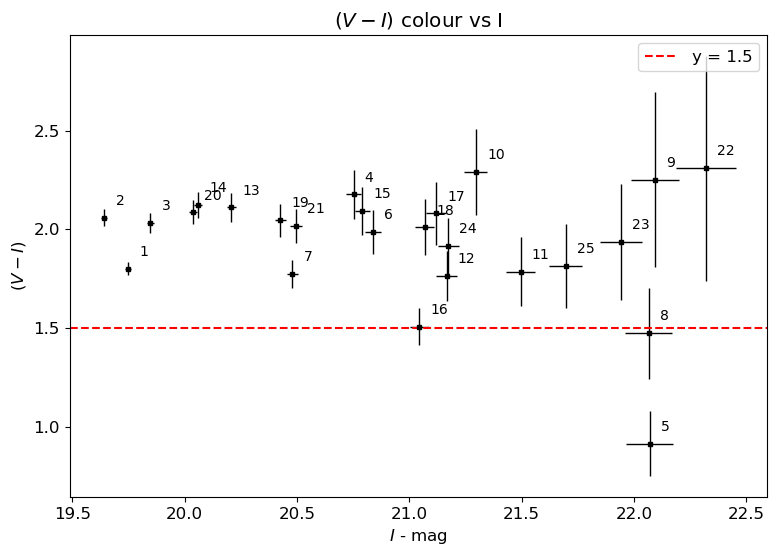

In [34]:
# Plot v-i versus i-mag

labels = np.arange(1, 26, 1)

plt.rcParams['font.size'] = 12
plt.figure(figsize=(9, 6))

plt.errorbar(i_mag_g, v_minus_i, xerr = i_mag_e_g, yerr = v_minus_i_e, color="black", marker="s", markersize = 3, elinewidth = 1, ls='none')

for i, label in enumerate(labels):
    plt.text(i_mag_g[i] + 0.05, v_minus_i[i] + 0.05, str(label), 
            fontsize=10, ha='left', va='bottom')

plt.axhline(y=1.5, color="red", linestyle="--", linewidth=1.5, label="y = 1.5")

plt.xlabel("$I$ - mag") 
plt.ylabel("$(V-I)$")
plt.title("$(V-I)$ colour vs I")
plt.legend()
plt.show()

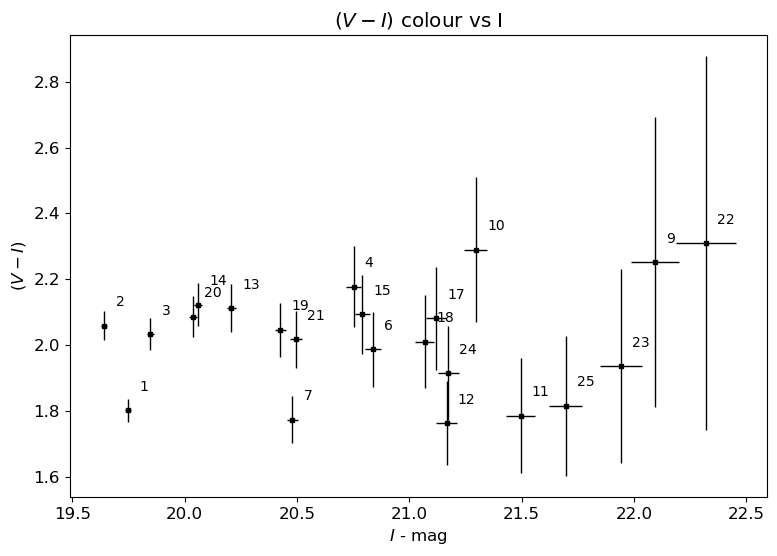

In [35]:
# Exclude point 8, 5, and 16

exclude_indices = [4, 7, 15]

# Create new lists excluding the specified indices
v_minus_i_modified = [v_minus_i[i] for i in range(len(v_minus_i)) if i not in exclude_indices]
i_mag_g_modified = [i_mag_g[i] for i in range(len(i_mag_g)) if i not in exclude_indices]
labels_modified = [labels[i] for i in range(len(labels)) if i not in exclude_indices]
i_mag_e_g_modified = [i_mag_e_g[i] for i in range(len(i_mag_e_g)) if i not in exclude_indices]
v_minus_i_e_modified = [v_minus_i_e[i] for i in range(len(v_minus_i_e)) if i not in exclude_indices]

plt.rcParams['font.size'] = 12
plt.figure(figsize=(9, 6))

plt.errorbar(i_mag_g_modified, v_minus_i_modified, xerr = i_mag_e_g_modified, yerr = v_minus_i_e_modified, color="black", marker="s", markersize = 3, elinewidth = 1, ls='none')

# Add labels
for i, label in enumerate(labels_modified):
    plt.text(i_mag_g_modified[i] + 0.05, v_minus_i_modified[i] + 0.05, str(label), 
            fontsize=10, ha='left', va='bottom')

#plt.axhline(y=1.5, color="red", linestyle="--", linewidth=1.5, label="y = 1.5")

# Labels and title
plt.xlabel("$I$ - mag") 
plt.ylabel("$(V-I)$")
plt.title("$(V-I)$ colour vs I")
#plt.legend()
plt.show()

In [36]:
from scipy import optimize as scopt

a = 0.019775245756110643
b = 1.576715296888137


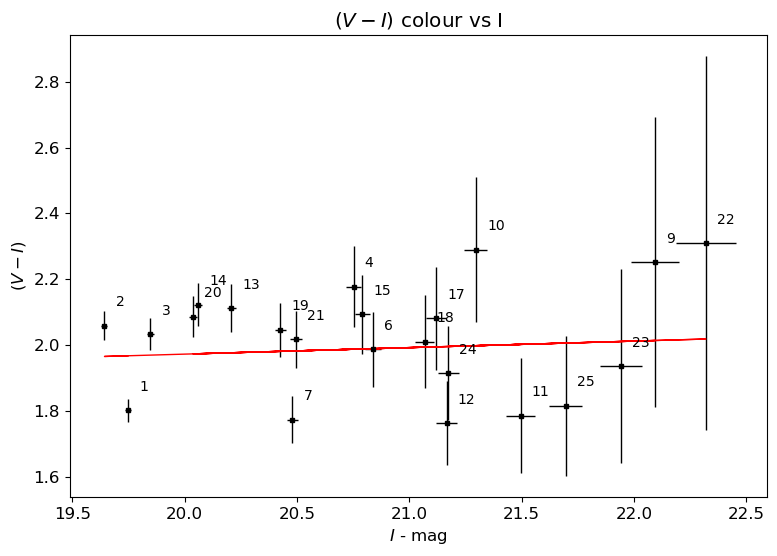

In [37]:
def func(X, a, b):
    return (a * X) + b

popt, pcov = scopt.curve_fit(func, i_mag_g_modified, v_minus_i_modified, sigma=v_minus_i_e_modified, absolute_sigma=True)

i_mag_g_modified_arr = np.array(i_mag_g_modified)

model = popt[0]*i_mag_g_modified_arr + popt[1]

print(f'a = {popt[0]}')
print(f'b = {popt[1]}')

plt.rcParams['font.size'] = 12
plt.figure(figsize=(9, 6))

plt.errorbar(i_mag_g_modified, v_minus_i_modified, xerr = i_mag_e_g_modified, yerr = v_minus_i_e_modified, color="black", marker="s", markersize = 3, elinewidth = 1, ls='none')

plt.plot(i_mag_g_modified, model, color="red", linewidth = 1)
# Add labels
for i, label in enumerate(labels_modified):
    plt.text(i_mag_g_modified[i] + 0.05, v_minus_i_modified[i] + 0.05, str(label), 
            fontsize=10, ha='left', va='bottom')

#plt.axhline(y=1.5, color="red", linestyle="--", linewidth=1.5, label="y = 1.5")

# Labels and title
plt.xlabel("$I$ - mag") 
plt.ylabel("$(V-I)$")
plt.title("$(V-I)$ colour vs I")
#plt.legend()
plt.show()

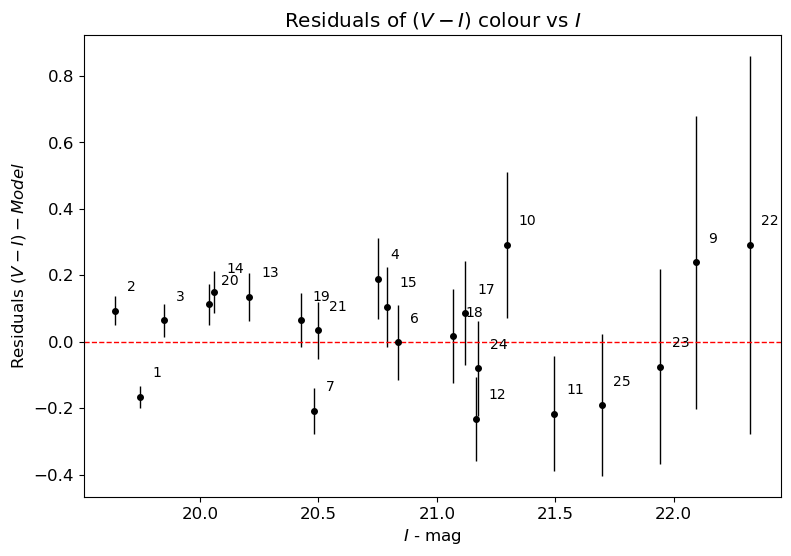

In [43]:
# Calculate residuals
residuals = v_minus_i_modified - model

# Plot residuals
plt.figure(figsize=(9, 6))
plt.errorbar(i_mag_g_modified, residuals, yerr=v_minus_i_e_modified, 
             color="black", marker="o", markersize=4, elinewidth=1, ls='none')
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Add labels on top of residuals
for i, label in enumerate(labels_modified):
    plt.text(i_mag_g_modified[i] + 0.05, residuals[i] + 0.05, str(label), 
             fontsize=10, ha='left', va='bottom')

# Labels and title
plt.xlabel("$I$ - mag") 
plt.ylabel("Residuals $(V-I) - Model$")
plt.title("Residuals of $(V-I)$ colour vs $I$")

plt.show()

